# Extract features, retrain Sherlock and generate predictions.

The script below first downloads the data (roughly 700K samples), then extract features from the raw data values. <br>
If you want to skip this step, you can follow the steps below the feature extraction to load the preprocessed data, 
retrain Sherlock and generate predictions.

In [374]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle5
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf

from sherlock import helpers
from sherlock.features import preprocessing
from sherlock.deploy.train_sherlock import train_sherlock
from sherlock.deploy.predict_sherlock import predict_sherlock
from sherlock.deploy import model_helpers
from sherlock.model import sherlock

In [365]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
RANDOM_STATE = 1

## Download data
This will download the raw values and preprocessed files, the corresponding labels as well as a few other supporting files:
- `download_data()` will download 3.6GB of data into the `data/` directory.
- `prepare_feature_extraction()` will download +/- 800 MB of data into the `features/` directory.

In [5]:
helpers.download_data()
preprocessing.prepare_feature_extraction()

Data was downloaded.
Preparing feature extraction by downloading 2 files:
        
 ../sherlock/features/glove.6B.50d.txt and 
 ../sherlock/features/par_vec_trained_400.pkl.docvecs.vectors_docs.npy.
        
All files for extracting word and paragraph embeddings are present.


In [6]:
feature_cols_dict = model_helpers.categorize_features()

## Read in raw data
You can skip this step if you want to use a preprocessed data file.

## WebTables data

In [7]:
test_samples = pd.read_parquet('../data/data/raw/test_values.parquet')
test_labels = pd.read_parquet('../data/data/raw/test_labels.parquet')

In [8]:
test_labels["type"].value_counts()[:20]

status         3100
category       3087
position       3057
artist         3043
description    3042
company        3041
day            3038
country        3038
album          3035
age            3033
state          3030
name           3017
year           3015
team           3011
address        3003
duration       3000
sex            2997
rank           2983
club           2977
class          2971
Name: type, dtype: int64

In [9]:
test_samples_converted, y_test = preprocessing.convert_string_lists_to_lists(test_samples, test_labels, "values", "type")

100%|██████████| 137353/137353 [04:10<00:00, 549.20it/s] 


In [10]:
test_samples_converted[:10]

20368     [Central Missouri, unattached, unattached, Kan...
664102    [95, 100, 95, 89, 84, 91, 88, 94, 75, 78, 90, ...
366813    [Katie Crews, Christian Hiraldo, Alex Estrada,...
530567    [Christian, Non-Christian, Unreported, Jewish,...
176253    [AAF-McQuay Canada Inc., AAF-McQuay Canada Inc...
327387    [05 - 08, 04 - 08, 06 - 09, 05 - 08, 06 - 08, ...
61176              [Cerulean Cave (1f), Route 14, Route 15]
194778    [libyaml, pyyaml, libyaml, pyyaml, pyyaml, pys...
180281    [Citiwest Consulting Ltd, Hunter Laird Enginee...
397103    [Various, Adams and Brooks, Atkinson's Candy, ...
Name: values, dtype: object

In [11]:
test_samples_converted.iloc[0]

['Central Missouri',
 'unattached',
 'unattached',
 'Kansas State University',
 'unattached',
 'North Dakota State',
 'Nike']

### GitTables data

In [13]:
gittables_object_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_object_column_values.pickle")

In [14]:
gittables_thing_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_thing_column_values.pickle")

In [15]:
gittables_id_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_id_column_values.pickle")

In [16]:
gittables_physical_entity_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_physical_entity_column_values.pickle")

In [17]:
gittables_living_thing_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_living_thing_column_values.pickle")

In [18]:
gittables_whole_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_whole_column_values.pickle")

In [19]:
gittables_organism_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_organism_column_values.pickle")

In [21]:
gittables_parent_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_parent_column_values.pickle")

In [22]:
gittables_dwarf_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_dwarf_column_values.pickle")

In [23]:
gittables_abstraction_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_abstraction_column_values.pickle")

In [273]:
gittables_all_samples = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_all_column_values.pickle")

In [28]:
gittables_object_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_object_column_types.pickle")

In [29]:
gittables_thing_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_thing_column_types.pickle")

In [30]:
gittables_id_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_id_column_types.pickle")

In [31]:
gittables_physical_entity_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_physical_entity_column_types.pickle")

In [32]:
gittables_living_thing_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_living_thing_column_types.pickle")

In [33]:
gittables_whole_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_whole_column_types.pickle")

In [34]:
gittables_organism_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_organism_column_types.pickle")

In [35]:
gittables_parent_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_parent_column_types.pickle")

In [36]:
gittables_dwarf_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_dwarf_column_types.pickle")

In [37]:
gittables_abstraction_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_abstraction_column_types.pickle")

In [277]:
gittables_all_labels = pd.read_pickle("../../../../../../../Volumes/ivi-inde/madelon/sherlock_experiment/gittables_all_column_types.pickle")

In [40]:
gittables_whole_samples.shape, gittables_organism_labels.shape

((14961,), (18128,))

In [39]:
gittables_thing_samples.shape, gittables_object_samples.shape, gittables_parent_samples.shape, gittables_id_labels.shape

((22480,), (35830,), (29166,), (62305,))

In [41]:
gittables_object_samples.head()

0    [Minecraft, FootballManager2019Mobile, Alien:B...
1    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
3    [INCOMPLETE, None, PASSED, PASSED, PASSED, PAS...
4    [SenSchumer, SenSchumer, SenSchumer, SenSchume...
Name: values, dtype: object

In [42]:
gittables_thing_samples.head()

0    [nwquah, None, None, None, None, None, None, N...
1    [I make Hot Pod, a newsletter about podcasts. ...
2    [None, None, Alexander, William, Ethan, Jacob,...
3    [Canada, Canada, Canada, Canada, Canada, Canad...
4    [null@Mr.com, null@day.com, Alexander@thing.co...
Name: values, dtype: object

In [43]:
pd.Series(gittables_object_labels).value_counts()

name           12495
description     4527
status          4299
rank            4231
class           3210
state           2584
year            1449
category        1017
sex              974
address          321
country          194
age              139
position         126
day              116
company           75
artist            43
album             14
team              14
club               2
Name: type, dtype: int64

In [44]:
pd.Series(gittables_thing_labels).value_counts()

name           7345
address        4330
country        3971
artist         1972
class           687
description     597
category        582
status          474
rank            472
year            469
album           342
position        306
age             224
state           219
day             209
sex             148
company         102
team             22
club              9
Name: type, dtype: int64

In [45]:
pd.Series(gittables_id_labels).value_counts()

name           32904
address         6766
status          6612
rank            5900
year            4817
description     1364
company         1189
category         542
country          521
team             463
class            246
state            194
artist           192
position         158
album            137
age              123
day              103
sex               74
Name: type, dtype: int64

In [46]:
pd.Series(gittables_parent_labels).value_counts()

name           10947
status          4684
description     4346
class           2677
state           1257
category        1079
year            1006
rank             803
address          609
country          587
position         496
age              287
company          142
sex               94
team              70
day               67
artist             9
club               3
album              3
Name: type, dtype: int64

In [48]:
gittables_samples = gittables_object_samples.append(
    [
        gittables_thing_samples, gittables_id_samples, gittables_physical_entity_samples, gittables_abstraction_samples,
        gittables_whole_samples, gittables_living_thing_samples, gittables_organism_samples, 
        gittables_parent_samples, gittables_dwarf_samples
    ]
).reset_index(drop=True)
gittables_labels = gittables_object_labels.append(
    [
        gittables_thing_labels, gittables_id_labels, gittables_physical_entity_labels, gittables_abstraction_labels,
        gittables_whole_labels, gittables_living_thing_labels, gittables_organism_labels, 
        gittables_parent_labels, gittables_dwarf_labels
    ]
).reset_index(drop=True)

In [49]:
gittables_labels.value_counts()

name           79988
class          24576
status         17705
description    16638
rank           15462
address        14287
year           14250
country         9037
state           7833
category        5810
artist          5156
age             4531
sex             2140
position        2031
company         1986
album           1137
day             1109
team             779
club              68
Name: type, dtype: int64

In [50]:
test_labels["type"].value_counts()[:20]

status         3100
category       3087
position       3057
artist         3043
description    3042
company        3041
day            3038
country        3038
album          3035
age            3033
state          3030
name           3017
year           3015
team           3011
address        3003
duration       3000
sex            2997
rank           2983
club           2977
class          2971
Name: type, dtype: int64

In [83]:
overlapping_types = ["name",  "class", "description", "status", "address"]

In [84]:
len(overlapping_types)

5

In [85]:
len(test_labels["type"].unique()), len(overlapping_types)

(78, 5)

In [91]:
gittables_samples_overlap = gittables_samples[gittables_labels.isin(overlapping_types)]
gittables_labels_overlap = gittables_labels[gittables_labels.isin(overlapping_types)]

In [92]:
gittables_samples_deduplicated = gittables_samples_overlap[~gittables_samples_overlap.astype(str).duplicated(keep="first")]
gittables_labels_deduplicated = gittables_labels_overlap[gittables_samples_deduplicated.index]

In [93]:
gittables_samples_deduplicated.head(n=5)

0    [Minecraft, FootballManager2019Mobile, Alien:B...
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
3    [INCOMPLETE, None, PASSED, PASSED, PASSED, PAS...
4    [SenSchumer, SenSchumer, SenSchumer, SenSchume...
5    [Document name code                           ...
Name: values, dtype: object

In [94]:
gittables_labels_deduplicated.head()

0           name
2    description
3         status
4           name
5           name
Name: type, dtype: object

In [95]:
gittables_samples_deduplicated.shape

(70491,)

In [96]:
gittables_labels_deduplicated.value_counts()

name           37480
class          17348
description     6500
address         5687
status          3476
Name: type, dtype: int64

In [97]:
webtables_samples_overlap = test_samples_converted[test_labels["type"].isin(overlapping_types)]
webtables_labels_overlap = test_labels[test_labels["type"].isin(overlapping_types)]

In [98]:
webtables_samples_deduplicated = webtables_samples_overlap[~webtables_samples_overlap.astype(str).duplicated(keep="first")]
webtables_labels_deduplicated = webtables_labels_overlap["type"][webtables_samples_deduplicated.index]

In [99]:
webtables_samples_overlap.head()

257827    [Free format text: ASSIGNMENT OF ASSIGNORS INT...
601769    [Status, Declined, Fixed, Declined, Declined, ...
2851                                    [120 PLEASANT ST, ]
256356    [Port Juk away from kde3support, Add support f...
268354    [Custom, i18ned display of (nominatim) reverse...
Name: values, dtype: object

In [100]:
webtables_labels_overlap.head()

,type
257827,description
601769,status
2851,address
256356,description
268354,description


In [115]:
webtables_labels_deduplicated.value_counts()

address        2948
name           2830
description    2752
status         2162
class          2148
Name: type, dtype: int64

In [101]:
webtables_samples_deduplicated.shape

(12840,)

In [289]:
gittables_all_samples_deduplicated = gittables_all_samples[~gittables_all_samples.astype(str).duplicated()]

In [290]:
gittables_all_labels_deduplicated = gittables_all_labels[gittables_all_samples_deduplicated.index]

In [291]:
len(gittables_all_samples_deduplicated)

41533

In [318]:
webtables_all_samples_deduplicated = test_samples_converted[~test_samples_converted.astype(str).duplicated()]

In [321]:
webtables_all_labels_deduplicated = test_labels["type"][webtables_all_samples_deduplicated.index]

In [324]:
webtables_all_labels_deduplicated.shape

(103299,)

### Balancing datasets

In [116]:
g = pd.DataFrame([gittables_labels_deduplicated, gittables_samples_deduplicated]).transpose().groupby(by='type')
# Number of types sampled
min_size_gittables = 2148
gittables_deduplicated_sampled = (
    g.apply(lambda x: x.sample(min_size_gittables, random_state=RANDOM_STATE).reset_index(drop=True))
    .reset_index(drop=True)
)

In [117]:
min_size_gittables

2148

In [118]:
gittables_deduplicated_sampled.head()

,type,values
0,address,"[Mason@study.com, James@student.com, Jacob@thi..."
1,address,"[hseitz@jccc.edu, lwolfgra@jccc.edu, bedmond3@..."
2,address,"[Alexander@school.com, Ethan@money.com, null@f..."
3,address,"[Jacob@hand.com, Jacob@week.com, James@thing.c..."
4,address,"[Alexander@job.com, null@time.com, James@money..."


In [119]:
gittables_deduplicated_sampled["type"].value_counts()

name           2148
class          2148
status         2148
description    2148
address        2148
Name: type, dtype: int64

In [120]:
g = pd.DataFrame([webtables_labels_deduplicated, webtables_samples_deduplicated]).transpose().groupby(by='type')
webtables_deduplicated_sampled = (
    g.apply(lambda x: x.sample(min_size_gittables, random_state=RANDOM_STATE).reset_index(drop=True))
    .reset_index(drop=True)
)

In [126]:
webtables_deduplicated_sampled.head()

,type,values
0,address,"[179, Witham Road, 196, Witham Road, 195, With..."
1,address,"[1, Bramhall Lane South, 1, Bramhall Lane Sout..."
2,address,"[Reading, Berkshire, RG7 Full Address, St Leon..."
3,address,"[3903 SKYRIDGE AVE San Antonio, TX 78210, 3823..."
4,address,"[238 HAZEL ST., , ]"


In [127]:
webtables_deduplicated_sampled["type"].value_counts()

name           2148
class          2148
status         2148
description    2148
address        2148
Name: type, dtype: int64

## Extract features
It is important that the string-representations of lists are first converted into lists of strings.
The labels should be a list of semantic types.

### WebTables

In [327]:
webtables_samples_distribution = webtables_all_samples_deduplicated.sample(n=10000, random_state=RANDOM_STATE)
webtables_labels_distribution = webtables_all_labels_deduplicated.sample(n=10000, random_state=RANDOM_STATE)

In [328]:
webtables_samples_distribution.head()

417166    [1st career game, 1st career hit, 1st career RBI]
509812         [None, 134311.0, 74700.0, 99072.0, 129357.0]
632582    [Boston Red Sox, New York Yankees, Milwaukee B...
378362                 [Horsens (Denmark), Rabat (Morocco)]
207071    [Afghanistan, Albania, Algeria, American Samoa...
Name: values, dtype: object

In [329]:
webtables_labels_distribution.head()

417166       notes
509812        rank
632582        team
378362    location
207071     country
Name: type, dtype: object

In [330]:
webtables_all_features = preprocessing.extract_features(webtables_samples_distribution)

Preparing feature extraction by downloading 2 files:
        
 ../sherlock/features/glove.6B.50d.txt and 
 ../sherlock/features/par_vec_trained_400.pkl.docvecs.vectors_docs.npy.
        
All files for extracting word and paragraph embeddings are present.


100%|██████████| 10000/10000 [38:35<00:00,  4.32it/s]    


In [333]:
webtables_all_features = webtables_all_features.fillna(webtables_all_features.mean())

In [331]:
gittables_samples_distribution = gittables_all_samples_deduplicated.sample(n=10000, random_state=RANDOM_STATE)
gittables_labels_distribution = gittables_all_labels_deduplicated.sample(n=10000, random_state=RANDOM_STATE)

In [332]:
gittables_all_features = preprocessing.extract_features(gittables_samples_distribution)

Preparing feature extraction by downloading 2 files:
        
 ../sherlock/features/glove.6B.50d.txt and 
 ../sherlock/features/par_vec_trained_400.pkl.docvecs.vectors_docs.npy.
        
All files for extracting word and paragraph embeddings are present.


100%|██████████| 10000/10000 [19:02<00:00,  8.75it/s]


In [334]:
gittables_all_features = gittables_all_features.fillna(gittables_all_features.mean())

In [129]:
webtables_analysis_features = preprocessing.extract_features(webtables_deduplicated_sampled["values"])

Preparing feature extraction by downloading 2 files:
        
 ../sherlock/features/glove.6B.50d.txt and 
 ../sherlock/features/par_vec_trained_400.pkl.docvecs.vectors_docs.npy.
        
All files for extracting word and paragraph embeddings are present.


100%|██████████| 10740/10740 [23:36<00:00,  7.58it/s]  


In [130]:
webtables_analysis_features = webtables_analysis_features.fillna(webtables_analysis_features.mean())

In [131]:
webtables_analysis_features.shape

(10740, 1188)

In [132]:
webtables_analysis_features.head()

,n_[0]-agg-any,n_[0]-agg-all,n_[0]-agg-mean,n_[0]-agg-var,n_[0]-agg-min,n_[0]-agg-max,n_[0]-agg-median,n_[0]-agg-sum,n_[0]-agg-kurtosis,n_[0]-agg-skewness,...,length-agg-min,length-agg-max,length-agg-median,length-agg-sum,length-agg-kurtosis,length-agg-skewness,none-agg-has,none-agg-percent,none-agg-num,none-agg-all
0,True,False,0.20,0.3600,0,2,0.0,2,5.111111,2.666667,...,15,16,16.0,159,5.111111,-2.666667,False,0.000000,0,False
1,False,False,0.00,0.0000,0,0,0.0,0,-3.000000,0.000000,...,22,22,22.0,220,-3.000000,0.000000,False,0.000000,0,False
2,True,False,0.08,0.0736,0,1,0.0,2,7.586957,3.096281,...,30,52,38.0,965,0.784529,0.949779,False,0.000000,0,False
3,True,False,1.70,0.6100,0,3,2.0,17,0.154260,-0.680065,...,35,40,37.0,373,-0.172950,0.428729,False,0.000000,0,False
4,False,False,0.00,0.0000,0,0,0.0,0,-3.000000,0.000000,...,0,13,0.0,13,-1.500000,0.707107,False,-0.666667,-2,False


In [133]:
webtables_deduplicated_sampled["type"].head()

0    address
1    address
2    address
3    address
4    address
Name: type, dtype: object

### GitTables

In [134]:
gittables_deduplicated_sampled["values"].head()

0    [Mason@study.com, James@student.com, Jacob@thi...
1    [hseitz@jccc.edu, lwolfgra@jccc.edu, bedmond3@...
2    [Alexander@school.com, Ethan@money.com, null@f...
3    [Jacob@hand.com, Jacob@week.com, James@thing.c...
4    [Alexander@job.com, null@time.com, James@money...
Name: values, dtype: object

In [135]:
gittables_deduplicated_sampled["type"].head()

0    address
1    address
2    address
3    address
4    address
Name: type, dtype: object

In [136]:
gittables_analysis_features = preprocessing.extract_features(gittables_deduplicated_sampled["values"]) 

Preparing feature extraction by downloading 2 files:
        
 ../sherlock/features/glove.6B.50d.txt and 
 ../sherlock/features/par_vec_trained_400.pkl.docvecs.vectors_docs.npy.
        
All files for extracting word and paragraph embeddings are present.


100%|██████████| 10740/10740 [20:12<00:00,  8.85it/s]


In [137]:
gittables_analysis_features = gittables_analysis_features.fillna(gittables_analysis_features.mean())

In [138]:
gittables_analysis_features.head(n=5)

,n_[0]-agg-any,n_[0]-agg-all,n_[0]-agg-mean,n_[0]-agg-var,n_[0]-agg-min,n_[0]-agg-max,n_[0]-agg-median,n_[0]-agg-sum,n_[0]-agg-kurtosis,n_[0]-agg-skewness,...,length-agg-min,length-agg-max,length-agg-median,length-agg-sum,length-agg-kurtosis,length-agg-skewness,none-agg-has,none-agg-percent,none-agg-num,none-agg-all
0,False,False,0.0,0.0,0,0,0.0,0,-3.0,0.0,...,12,21,14.0,467,1.236294,1.084834,False,0.0,0,False
1,False,False,0.0,0.0,0,0,0.0,0,-3.0,0.0,...,3,17,14.0,68,-1.516339,-0.557686,False,0.0,0,False
2,False,False,0.0,0.0,0,0,0.0,0,-3.0,0.0,...,10,22,16.0,491,-0.049900,0.241513,False,0.0,0,False
3,False,False,0.0,0.0,0,0,0.0,0,-3.0,0.0,...,14,15,14.5,58,-2.000000,0.000000,False,0.0,0,False
4,False,False,0.0,0.0,0,0,0.0,0,-3.0,0.0,...,12,18,15.0,372,-0.882281,0.138859,False,0.0,0,False


### Save files

In [476]:
webtables_analysis_features.to_pickle("../data/gittables_experiment/webtables_analysis_features.pkl", protocol=4)
webtables_deduplicated_sampled["type"].to_pickle("../data/gittables_experiment/webtables_analysis_labels.pkl", protocol=4)

In [477]:
gittables_analysis_features.to_pickle("../data/gittables_experiment/gittables_analysis_features.pkl", protocol=4)
gittables_deduplicated_sampled["type"].to_pickle("../data/gittables_experiment/gittables_analysis_labels.pkl", protocol=4)

In [478]:
gittables_all_features.to_pickle("../data/gittables_experiment/gittables_all_features.pkl", protocol=4)
webtables_all_features.to_pickle("../data/gittables_experiment/webtables_all_features.pkl", protocol=4)

In [141]:
print(gittables_analysis_features["word_embedding_feature"].sum())
print(webtables_analysis_features["word_embedding_feature"].sum())

7840
10515


## Analyse featurized content
-> we inspect data diversity coverage of WebTables and GitTables

In [142]:
webtables_gittables_df = webtables_analysis_features.append(gittables_analysis_features)

In [336]:
webtables_gittables_all_df = webtables_all_features.append(gittables_all_features)

In [143]:
webtables_gittables_df.shape

(21480, 1188)

In [337]:
webtables_gittables_all_df.shape

(20000, 1188)

In [338]:
data_shift_labels = np.ones(webtables_all_features.shape[0]).tolist() + np.zeros(gittables_all_features.shape[0]).tolist()

In [339]:
visualization_labels = np.repeat("black", webtables_all_features.shape[0]).tolist() + np.repeat("red", gittables_all_features.shape[0]).tolist()

In [340]:
corpus_labels = np.repeat("WebTables", webtables_all_features.shape[0]).tolist() + np.repeat("GitTables", gittables_all_features.shape[0]).tolist() 

### Visualizing compressed feature spaces

In [341]:
from sklearn import manifold, decomposition
import matplotlib

In [342]:
tsne = manifold.TSNE(n_components=2, perplexity=75, random_state=RANDOM_STATE)

In [343]:
tsne_compression = pd.DataFrame(
    tsne.fit_transform(webtables_gittables_all_df),
    columns=["x", "y"],
)

In [344]:
tsne_compression.head()

,x,y
0,-45.531780,19.574947
1,-30.340124,-24.437840
2,12.729100,16.075064
3,-55.479752,13.607750
4,27.667137,-7.479201


In [1]:
# tsne perplexity
plt.figure(figsize=(12,7))

plt.scatter(tsne_compression.loc[:webtables_all_features.shape[0], "x"], tsne_compression.loc[:webtables_all_features.shape[0],"y"], c="gold", label="WebTables", alpha=0.2)
plt.scatter(tsne_compression.loc[gittables_all_features.shape[0]:, "x"], tsne_compression.loc[gittables_all_features.shape[0]:,"y"], c="cornflowerblue", label="GitTables", alpha=0.2)

plt.tick_params(axis="both", which="both", length=0, labelsize=20)
plt.tick_params(axis="both", which="both", length=0, labelsize=20)

plt.legend(fontsize=24, scatterpoints=6, loc="lower left")

In [2]:
plt.scatter(tsne_compression.loc[:webtables_all_features.shape[0], "x"], tsne_compression.loc[:webtables_all_features.shape[0],"y"], c="gold", label="WebTables", alpha=0.2)

In [3]:
plt.scatter(tsne_compression.loc[gittables_all_features.shape[0]:, "x"], tsne_compression.loc[gittables_all_features.shape[0]:,"y"], c="cornflowerblue", label="GitTables", alpha=0.2)

In [247]:
plt.savefig("../data/gittables_experiment/tsne_gittables_webtables.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

### Detecting distribution differences

In [250]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import sklearn

In [354]:
cv = model_selection.KFold(n_splits=10, random_state=RANDOM_STATE)

In [355]:
models_scores = model_selection.cross_validate(
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    webtables_gittables_all_df,
    y=data_shift_labels,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

In [358]:
np.mean(models_scores["test_score"])

0.9020999999999999

In [359]:
models_scores["test_score"]

array([0.9235, 0.939 , 0.9405, 0.9245, 0.924 , 0.8785, 0.8625, 0.8775,
       0.879 , 0.872 ])

In [360]:
models_scores["train_score"]

array([0.99972222, 0.99955556, 0.99955556, 0.99972222, 0.99966667,
       0.99972222, 0.99955556, 0.99972222, 0.99961111, 0.99955556])

In [361]:
np.std(models_scores["test_score"])

0.029060970389854494

In [352]:
from matplotlib import ticker

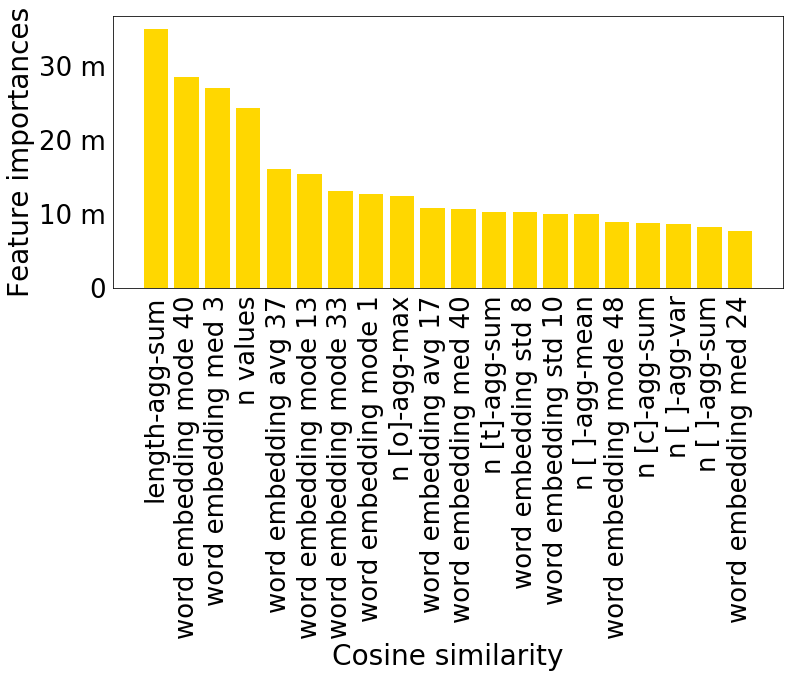

In [353]:
plt.figure(figsize=(12,5))
ax = plt.gca()

plt.bar(
    x=webtables_gittables_all_df.columns[list(np.argsort(models_scores["estimator"][0].feature_importances_))[::-1]][:20].str.replace("_", " "),
    height=list(np.sort(models_scores["estimator"][0].feature_importances_))[::-1][:20],
    color="gold"
)

for tick in ax.get_xticklabels(): tick.set_rotation(90)
    
ax.set_ylabel("Feature importances", fontsize=28)
ax.set_xlabel("Cosine similarity", fontsize=28)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.tick_params(axis='both', which='major', labelsize=26)

plt.show()

## How well do the corpora generalize?
The model can be retrained using the code below. The model is currently restricted to be trained on 78 classes, the code of the model architecture will soon be added for adjusting this.

In [193]:
from sklearn import metrics

In [259]:
gittables_models_scores = model_selection.cross_validate(
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    gittables_analysis_features,
    gittables_deduplicated_sampled["type"],
    cv=10,
    return_estimator=True,
    scoring="f1_macro",
)

In [260]:
np.mean(gittables_models_scores["test_score"]), np.std(gittables_models_scores["test_score"])

(0.9071976061276249, 0.006416250014179148)

In [261]:
np.mean(gittables_models_scores["train_score"])

/Users/madelon/miniconda3/envs/sherlock-project/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.9998137904084585

In [262]:
gittables_prediction_for_webtables = gittables_models_scores["estimator"][0].predict(webtables_analysis_features)

In [263]:
#gittables_analysis_features.columns[list(np.argsort(gittables_models_scores["estimator"][0].feature_importances_))[::-1]][:20]

In [264]:
len(gittables_prediction_for_webtables)

10740

In [265]:
gittables_test_scores = []
for estimator in gittables_models_scores["estimator"]:
    gittables_prediction_for_webtables = estimator.predict(webtables_analysis_features)
    gittables_test_scores.append(
        metrics.f1_score(webtables_deduplicated_sampled["type"], gittables_prediction_for_webtables, average="macro")
    )

In [266]:
gittables_test_scores

[0.6106779875913098,
 0.6234191403838294,
 0.6365295195306914,
 0.6242079804345727,
 0.6057023570274521,
 0.5992040636007553,
 0.6228251120844833,
 0.6021187237010104,
 0.6323966941284482,
 0.6234341803505956]

In [267]:
np.mean(gittables_test_scores), np.std(gittables_test_scores)

(0.6180515758833147, 0.012172286029492808)

In [268]:
webtables_models_scores = model_selection.cross_validate(
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    webtables_analysis_features,
    webtables_deduplicated_sampled["type"],
    cv=10,
    return_estimator=True,
    scoring="f1_weighted",
)

In [269]:
np.mean(webtables_models_scores["test_score"]), np.std(webtables_models_scores["test_score"])

(0.9113759987095555, 0.00828232590697439)

In [270]:
webtables_test_scores = []
for estimator in webtables_models_scores["estimator"]:
    webtables_prediction_for_gittables = estimator.predict(gittables_analysis_features)
    webtables_test_scores.append(
        metrics.f1_score(gittables_deduplicated_sampled["type"], webtables_prediction_for_gittables, average="macro")
    )

In [271]:
webtables_test_scores

[0.572004574328487,
 0.577650327849879,
 0.5656991056445559,
 0.5850738452954166,
 0.5557575536693453,
 0.5291899540904167,
 0.5592650559098961,
 0.5642112441219224,
 0.552582929570887,
 0.5613832420136954]

In [272]:
np.mean(webtables_test_scores), np.std(webtables_test_scores)

(0.5622817832494501, 0.014516247259522561)

## Semantic type detection in GitTables

In [443]:
from sklearn import model_selection

In [466]:
gittables_test_scores = []

kf = model_selection.StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)
X = gittables_analysis_features
y = gittables_deduplicated_sampled["type"]
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train_git, X_test_git = X.loc[train_index], X.loc[test_index]
    y_train_git, y_test_git = y.loc[train_index], y.loc[test_index]
    X_train_git, X_val_git, y_train_git, y_val_git = model_selection.train_test_split(X_train_git, y_train_git, test_size=0.1, random_state=RANDOM_STATE)
    
    sherlock.build_sherlock(
        X_train_git[feature_cols_dict["char"]],
        X_train_git[feature_cols_dict["word"]],
        X_train_git[feature_cols_dict["rest"]],
        X_val_git[feature_cols_dict["char"]],
        X_val_git[feature_cols_dict["word"]],
        X_val_git[feature_cols_dict["rest"]],
        y_train_git,
        y_val_git,
        f"gittables_{fold}"
    )
    
    predicted_labels = predict_sherlock(X_test_git, nn_id=f'gittables_{fold}')    
    gittables_test_scores.append(f1_score(y_test_git, predicted_labels, average="macro"))

Train on 7731 samples, validate on 859 samples
Epoch 1/100
7731/7731 [==============================] - 8s 1ms/sample - loss: 340.0364 - categorical_accuracy: 0.4051 - val_loss: 318.5982 - val_categorical_accuracy: 0.5111
Epoch 2/100
7731/7731 [==============================] - 3s 360us/sample - loss: 300.6055 - categorical_accuracy: 0.6502 - val_loss: 281.6246 - val_categorical_accuracy: 0.7020
Epoch 3/100
7731/7731 [==============================] - 3s 362us/sample - loss: 265.5437 - categorical_accuracy: 0.7206 - val_loss: 248.6926 - val_categorical_accuracy: 0.7742
Epoch 4/100
7731/7731 [==============================] - 3s 358us/sample - loss: 234.3754 - categorical_accuracy: 0.7544 - val_loss: 219.3723 - val_categorical_accuracy: 0.7893
Epoch 5/100
7731/7731 [==============================] - 3s 362us/sample - loss: 206.6350 - categorical_accuracy: 0.7796 - val_loss: 193.2728 - val_categorical_accuracy: 0.7998
Epoch 6/100
7731/7731 [==============================] - 3s 363us/samp

7731/7731 [==============================] - 3s 365us/sample - loss: 16.5775 - categorical_accuracy: 0.8431 - val_loss: 15.2872 - val_categorical_accuracy: 0.8428
Epoch 24/100
7731/7731 [==============================] - 3s 364us/sample - loss: 14.2628 - categorical_accuracy: 0.8418 - val_loss: 13.1533 - val_categorical_accuracy: 0.8452
Epoch 25/100
7731/7731 [==============================] - 3s 360us/sample - loss: 12.2753 - categorical_accuracy: 0.8397 - val_loss: 11.3266 - val_categorical_accuracy: 0.8475
Epoch 26/100
7731/7731 [==============================] - 3s 359us/sample - loss: 10.5750 - categorical_accuracy: 0.8443 - val_loss: 9.7671 - val_categorical_accuracy: 0.8463
Epoch 27/100
7731/7731 [==============================] - 3s 356us/sample - loss: 9.1280 - categorical_accuracy: 0.8412 - val_loss: 8.4408 - val_categorical_accuracy: 0.8463
Epoch 28/100
7731/7731 [==============================] - 3s 356us/sample - loss: 7.8954 - categorical_accuracy: 0.8436 - val_loss: 7.31

In [467]:
np.mean(gittables_test_scores), np.std(gittables_test_scores)

(0.8218355485769594, 0.006673332796831863)

In [468]:
webtables_test_scores = []
kf = model_selection.StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)
X = webtables_analysis_features
y = webtables_deduplicated_sampled["type"]
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train_web, X_test_web = X.loc[train_index], X.loc[test_index]
    y_train_web, y_test_web = y.loc[train_index], y.loc[test_index]
    X_train_web, X_val_web, y_train_web, y_val_web = model_selection.train_test_split(X_train_web, y_train_web, test_size=0.1, random_state=RANDOM_STATE)
    
    sherlock.build_sherlock(
        X_train_web[feature_cols_dict["char"]],
        X_train_web[feature_cols_dict["word"]],
        X_train_web[feature_cols_dict["rest"]],
        X_val_web[feature_cols_dict["char"]],
        X_val_web[feature_cols_dict["word"]],
        X_val_web[feature_cols_dict["rest"]],
        y_train_web,
        y_val_web,
        f"webtables_{fold}"
    )
    
    predicted_labels = predict_sherlock(X_test_web, nn_id=f'webtables_{fold}')    
    webtables_test_scores.append(f1_score(y_test_web, predicted_labels, average="macro"))

Train on 7731 samples, validate on 859 samples
Epoch 1/100
7731/7731 [==============================] - 9s 1ms/sample - loss: 339.8692 - categorical_accuracy: 0.3901 - val_loss: 318.4944 - val_categorical_accuracy: 0.4983
Epoch 2/100
7731/7731 [==============================] - 3s 368us/sample - loss: 300.4449 - categorical_accuracy: 0.6680 - val_loss: 281.5108 - val_categorical_accuracy: 0.7520
Epoch 3/100
7731/7731 [==============================] - 3s 367us/sample - loss: 265.3598 - categorical_accuracy: 0.7529 - val_loss: 248.5694 - val_categorical_accuracy: 0.8056
Epoch 4/100
7731/7731 [==============================] - 3s 371us/sample - loss: 234.1833 - categorical_accuracy: 0.7845 - val_loss: 219.2311 - val_categorical_accuracy: 0.8207
Epoch 5/100
7731/7731 [==============================] - 3s 366us/sample - loss: 206.4450 - categorical_accuracy: 0.7999 - val_loss: 193.1164 - val_categorical_accuracy: 0.8242
Epoch 6/100
7731/7731 [==============================] - 3s 387us/samp

7731/7731 [==============================] - 3s 368us/sample - loss: 1.3956 - categorical_accuracy: 0.9282 - val_loss: 1.4817 - val_categorical_accuracy: 0.9034
Epoch 95/100
7731/7731 [==============================] - 3s 372us/sample - loss: 1.3897 - categorical_accuracy: 0.9289 - val_loss: 1.4795 - val_categorical_accuracy: 0.9045
Epoch 96/100
7731/7731 [==============================] - 3s 356us/sample - loss: 1.3871 - categorical_accuracy: 0.9296 - val_loss: 1.4791 - val_categorical_accuracy: 0.9022
Epoch 97/100
7731/7731 [==============================] - 3s 366us/sample - loss: 1.3820 - categorical_accuracy: 0.9316 - val_loss: 1.4730 - val_categorical_accuracy: 0.9080
Epoch 98/100
7731/7731 [==============================] - 3s 366us/sample - loss: 1.3769 - categorical_accuracy: 0.9331 - val_loss: 1.4734 - val_categorical_accuracy: 0.9080
Epoch 99/100
7731/7731 [==============================] - 3s 366us/sample - loss: 1.3747 - categorical_accuracy: 0.9334 - val_loss: 1.4727 - va

7731/7731 [==============================] - 3s 376us/sample - loss: 1.4270 - categorical_accuracy: 0.9217 - val_loss: 1.4860 - val_categorical_accuracy: 0.9139
Epoch 88/100
7731/7731 [==============================] - 3s 371us/sample - loss: 1.4245 - categorical_accuracy: 0.9220 - val_loss: 1.4831 - val_categorical_accuracy: 0.9115
Epoch 89/100
7731/7731 [==============================] - 3s 382us/sample - loss: 1.4174 - categorical_accuracy: 0.9255 - val_loss: 1.4820 - val_categorical_accuracy: 0.9115
Epoch 90/100
7731/7731 [==============================] - 3s 374us/sample - loss: 1.4136 - categorical_accuracy: 0.9258 - val_loss: 1.4809 - val_categorical_accuracy: 0.9115
Epoch 91/100
7731/7731 [==============================] - 3s 372us/sample - loss: 1.4081 - categorical_accuracy: 0.9258 - val_loss: 1.4776 - val_categorical_accuracy: 0.9139
Epoch 92/100
7731/7731 [==============================] - 3s 373us/sample - loss: 1.4050 - categorical_accuracy: 0.9274 - val_loss: 1.4744 - va

7731/7731 [==============================] - 3s 383us/sample - loss: 1.4544 - categorical_accuracy: 0.9201 - val_loss: 1.5094 - val_categorical_accuracy: 0.9034
Epoch 81/100
7731/7731 [==============================] - 3s 385us/sample - loss: 1.4510 - categorical_accuracy: 0.9202 - val_loss: 1.5044 - val_categorical_accuracy: 0.9080
Epoch 82/100
7731/7731 [==============================] - 3s 403us/sample - loss: 1.4461 - categorical_accuracy: 0.9212 - val_loss: 1.5043 - val_categorical_accuracy: 0.9069
Epoch 83/100
7731/7731 [==============================] - 3s 390us/sample - loss: 1.4421 - categorical_accuracy: 0.9215 - val_loss: 1.5005 - val_categorical_accuracy: 0.9080
Epoch 84/100
7731/7731 [==============================] - 3s 370us/sample - loss: 1.4362 - categorical_accuracy: 0.9259 - val_loss: 1.5001 - val_categorical_accuracy: 0.9069
Epoch 85/100
7731/7731 [==============================] - 3s 370us/sample - loss: 1.4308 - categorical_accuracy: 0.9239 - val_loss: 1.4978 - va

7735/7735 [==============================] - 3s 362us/sample - loss: 1.4920 - categorical_accuracy: 0.9154 - val_loss: 1.5261 - val_categorical_accuracy: 0.9151
Epoch 74/100
7735/7735 [==============================] - 3s 362us/sample - loss: 1.4878 - categorical_accuracy: 0.9138 - val_loss: 1.5229 - val_categorical_accuracy: 0.9163
Epoch 75/100
7735/7735 [==============================] - 3s 364us/sample - loss: 1.4804 - categorical_accuracy: 0.9144 - val_loss: 1.5201 - val_categorical_accuracy: 0.9163
Epoch 76/100
7735/7735 [==============================] - 3s 366us/sample - loss: 1.4770 - categorical_accuracy: 0.9144 - val_loss: 1.5161 - val_categorical_accuracy: 0.9174
Epoch 77/100
7735/7735 [==============================] - 3s 370us/sample - loss: 1.4754 - categorical_accuracy: 0.9136 - val_loss: 1.5128 - val_categorical_accuracy: 0.9186
Epoch 78/100
7735/7735 [==============================] - 3s 368us/sample - loss: 1.4654 - categorical_accuracy: 0.9197 - val_loss: 1.5109 - va

7735/7735 [==============================] - 3s 361us/sample - loss: 1.5281 - categorical_accuracy: 0.9070 - val_loss: 1.5480 - val_categorical_accuracy: 0.9070
Epoch 67/100
7735/7735 [==============================] - 3s 363us/sample - loss: 1.5227 - categorical_accuracy: 0.9070 - val_loss: 1.5446 - val_categorical_accuracy: 0.9081
Epoch 68/100
7735/7735 [==============================] - 3s 362us/sample - loss: 1.5169 - categorical_accuracy: 0.9100 - val_loss: 1.5433 - val_categorical_accuracy: 0.9070
Epoch 69/100
7735/7735 [==============================] - 3s 363us/sample - loss: 1.5114 - categorical_accuracy: 0.9099 - val_loss: 1.5363 - val_categorical_accuracy: 0.9093
Epoch 70/100
7735/7735 [==============================] - 3s 362us/sample - loss: 1.5071 - categorical_accuracy: 0.9083 - val_loss: 1.5327 - val_categorical_accuracy: 0.9093
Epoch 71/100
7735/7735 [==============================] - 3s 362us/sample - loss: 1.5025 - categorical_accuracy: 0.9100 - val_loss: 1.5290 - va

In [469]:
np.mean(webtables_test_scores), np.std(webtables_test_scores)

(0.8970319830205458, 0.005816997183459325)

### How well does a WebTables model generalize to GitTables

In [470]:
webtables_gittables_test_scores = []

for fold in [0,1,2,3,4]:
    predicted_labels = predict_sherlock(X_test_git, nn_id=f'webtables_{fold}')
    webtables_gittables_test_scores.append(
        f1_score(y_test_git, predicted_labels, average="macro")
    )

In [471]:
webtables_gittables_test_scores

[0.6577778845689572,
 0.6660475896270208,
 0.5644084203345683,
 0.6572316330220901,
 0.544669490878847]

In [472]:
np.mean(webtables_gittables_test_scores), np.std(webtables_gittables_test_scores)

(0.6180270036862966, 0.05230561983637378)

In [475]:
y_test_git.value_counts()

address        429
class          429
status         429
name           429
description    429
Name: type, dtype: int64